Loading your custom model from /content/CNN.h5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Emotion-Based Music Recommendation System
----------------------------------------
Using your custom CNN model and Spotify dataset

Using image from: /content/neutral.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


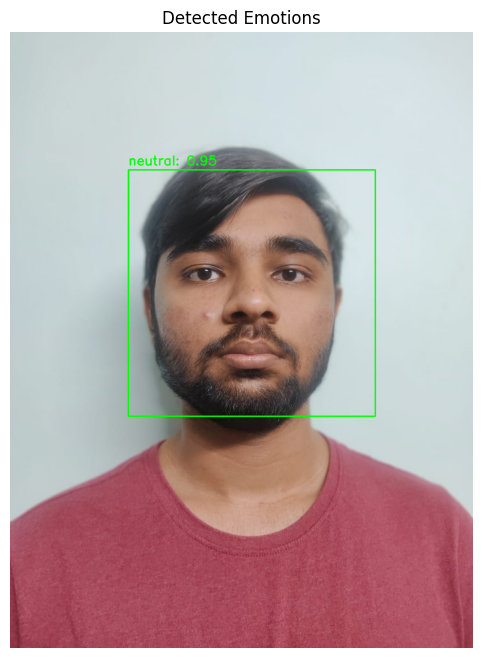

Detection completed in 0.7141 seconds
Face 1: neutral (Confidence: 0.9467)
Successfully loaded Spotify dataset with 1901 songs.
Successfully mapped Spotify data to the required format.

Music Dataset Overview:
Total songs: 1901
Available columns: ['track_id', 'track_name', 'artists', 'album', 'release_year', 'duration_ms', 'mood']
Genres/Moods: ['happy' 'sad' 'calm' 'energetic']

--- Recommendations for Face 1 (neutral) ---

Method 1: Emotion-to-Genre Mapping
                      track_name  \
637                  Tum Jo Milo   
1331  Aas Paas Khuda (Unplugged)   
712                  Ye Shaamein   
659           Fallin' All In You   
1119              Co2 - Acoustic   

                                             artists  \
637                      Pritam, Abhijeet Srivastava   
1331             Rahat Fateh Ali Khan, Shruti Pathak   
712   Vikaas Vishwakarma, Ram Chauhan, Pragati Shahi   
659                                     Shawn Mendes   
1119                                   

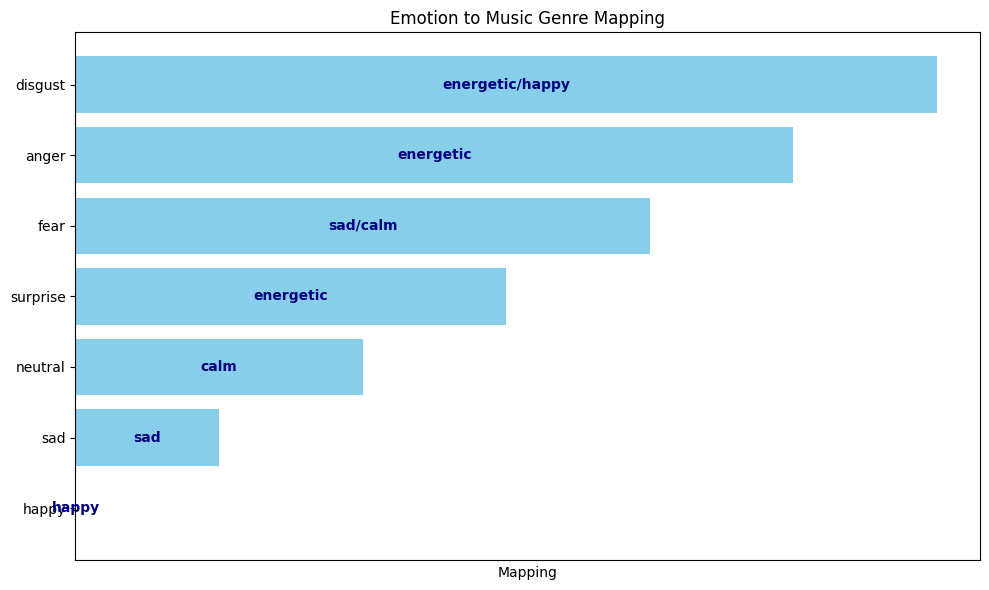


Genre Distribution in Dataset:


<ipython-input-21-206372ee2e0c>:491: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




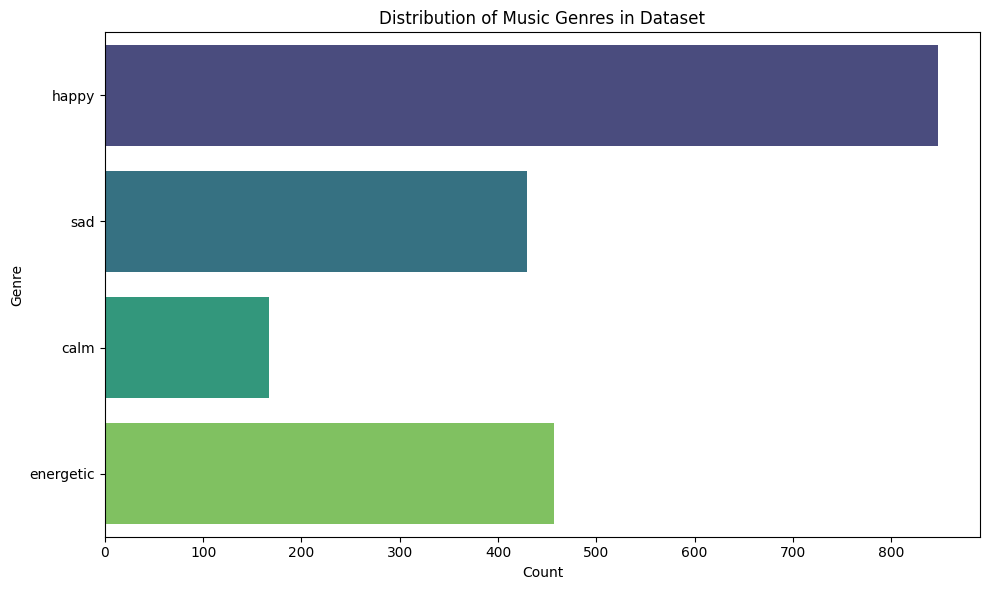

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import cv2
import time
from PIL import Image
import random
import os

# Define emotion to music genre mapping
emotion_to_genre = {
    'happy': 'happy',
    'sad': 'sad',
    'neutral': 'calm',
    'surprise': 'energetic',
    'fear': ['sad', 'calm'],  # Multiple options
    'anger': 'energetic',
    'disgust': ['energetic', 'happy']  # Multiple options
}

# List of emotion labels from FER2013
emotion_labels = ['anger', 'disgust', 'fear', 'happy', 'neutral','sad', 'surprise']

# Load custom CNN model
def load_custom_model():
    model_path = '/content/CNN.h5'

    if os.path.exists(model_path):
        print(f"Loading your custom model from {model_path}")
        return load_model(model_path)
    else:
        print(f"Error: Custom model not found at {model_path}")
        return None

# Load the emotion model
emotion_model = load_custom_model()

# Function to preprocess an image for emotion detection
def preprocess_image(image):
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Resize to 48x48 as expected by the model
    resized = cv2.resize(gray, (48, 48))

    # Normalize pixel values
    normalized = resized / 255.0

    # Expand dims to shape (48, 48, 1)
    gray_3d = np.expand_dims(normalized, axis=-1)

    # Repeat channels to make shape (48, 48, 3)
    rgb_like = np.repeat(gray_3d, 3, axis=-1)

    # Expand batch dimension to (1, 48, 48, 3)
    input_data = np.expand_dims(rgb_like, axis=0)

    return input_data

# Function to detect emotion from an image
def detect_emotion(image):
    start_time = time.time()

    # Preprocess the image
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = emotion_model.predict(processed_image)

    # Get the emotion label and probability
    emotion_idx = np.argmax(prediction)
    emotion = emotion_labels[emotion_idx]
    probability = prediction[0][emotion_idx]

    # Calculate latency
    latency = time.time() - start_time

    return emotion, probability, latency

# Function to detect faces and emotions in an image
def detect_faces_and_emotions(image):
    # Load the pre-trained face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert to grayscale for face detection
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    results = []
    start_time = time.time()

    # If no faces found, process the whole image
    if len(faces) == 0:
        emotion, probability, _ = detect_emotion(gray)
        results.append({
            'box': [0, 0, gray.shape[1], gray.shape[0]],
            'emotion': emotion,
            'probability': probability
        })
    else:
        # Process each detected face
        for (x, y, w, h) in faces:
            face = gray[y:y+h, x:x+w]
            emotion, probability, _ = detect_emotion(face)
            results.append({
                'box': [x, y, w, h],
                'emotion': emotion,
                'probability': probability
            })

    # Calculate overall latency
    latency = time.time() - start_time

    return results, latency

# Function to draw results on image
def draw_results(image, results):
    output = image.copy()

    for result in results:
        x, y, w, h = result['box']
        emotion = result['emotion']
        probability = result['probability']

        # Draw rectangle around face
        cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Add text with emotion and probability
        text = f"{emotion}: {probability:.2f}"
        cv2.putText(output, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return output

# Load custom Spotify dataset
def load_spotify_data():
    file_path = '/content/Spotify_updated.csv'

    if os.path.exists(file_path):
        data = pd.read_csv(file_path)
        print(f"Successfully loaded Spotify dataset with {len(data)} songs.")

        # Map the Spotify dataset columns to expected format
        try:
            # Check if the necessary columns exist
            existing_columns = data.columns.tolist()

            # Create a new DataFrame with the expected format
            formatted_data = pd.DataFrame()

            # Map track_id
            if 'id' in existing_columns:
                formatted_data['track_id'] = data['id']
            elif 'track_id' in existing_columns:
                formatted_data['track_id'] = data['track_id']
            else:
                formatted_data['track_id'] = [f"T{i:03d}" for i in range(len(data))]

            # Map track_name
            if 'name' in existing_columns:
                formatted_data['track_name'] = data['name']
            elif 'track_name' in existing_columns:
                formatted_data['track_name'] = data['track_name']
            else:
                formatted_data['track_name'] = "Unknown Track"

            # Map artists
            if 'artists' in existing_columns:
                formatted_data['artists'] = data['artists']
            elif 'artist_name' in existing_columns:
                formatted_data['artists'] = data['artist_name']
            else:
                formatted_data['artists'] = "Unknown Artist"

            # Map album
            if 'album' in existing_columns:
                formatted_data['album'] = data['album']
            elif 'album_name' in existing_columns:
                formatted_data['album'] = data['album_name']
            else:
                formatted_data['album'] = "Unknown Album"

            # Map release_year
            if 'release_year' in existing_columns:
                formatted_data['release_year'] = data['release_year']
            elif 'release_date' in existing_columns:
                # Extract year from release_date
                formatted_data['release_year'] = pd.to_datetime(data['release_date'], errors='coerce').dt.year
            else:
                formatted_data['release_year'] = 2023

            # Map duration_ms
            if 'duration_ms' in existing_columns:
                formatted_data['duration_ms'] = data['duration_ms']
            else:
                formatted_data['duration_ms'] = 200000  # Default duration

            # Map mood/genre based on available features
            if 'mood' in existing_columns:
                formatted_data['mood'] = data['mood']
            elif 'energy' in existing_columns and 'valence' in existing_columns:
                # Create mood based on energy and valence
                moods = []
                for _, row in data.iterrows():
                    energy = row['energy']
                    valence = row['valence']

                    if valence > 0.7:
                        mood = 'happy'
                    elif valence < 0.3:
                        mood = 'sad'
                    elif energy > 0.7:
                        mood = 'energetic'
                    else:
                        mood = 'calm'

                    moods.append(mood)

                formatted_data['mood'] = moods
            else:
                # Assign random moods as fallback
                formatted_data['mood'] = random.choices(['happy', 'sad', 'energetic', 'calm'], k=len(data))

            print("Successfully mapped Spotify data to the required format.")
            return formatted_data

        except Exception as e:
            print(f"Error processing Spotify data: {e}")
            print("Using the original data format instead.")

            # If mapping fails, try to use the original data as-is
            if 'mood' not in data.columns:
                # Create a mood column if it doesn't exist
                print("Creating mood column based on available audio features...")
                if 'energy' in data.columns and 'valence' in data.columns:
                    # Create mood based on energy and valence
                    moods = []
                    for _, row in data.iterrows():
                        energy = row['energy'] if not pd.isna(row['energy']) else 0.5
                        valence = row['valence'] if not pd.isna(row['valence']) else 0.5

                        if valence > 0.7:
                            mood = 'happy'
                        elif valence < 0.3:
                            mood = 'sad'
                        elif energy > 0.7:
                            mood = 'energetic'
                        else:
                            mood = 'calm'

                        moods.append(mood)

                    data['mood'] = moods
                else:
                    # Assign random moods as fallback
                    data['mood'] = random.choices(['happy', 'sad', 'energetic', 'calm'], k=len(data))

            return data
    else:
        print(f"Error: Spotify dataset not found at {file_path}")
        print("Creating a sample music dataset instead...")
        return create_sample_music_dataset()

# Function to create a sample music dataset (fallback if Spotify data not found)
def create_sample_music_dataset():
    print("Creating a sample music dataset...")

    # Create a diverse sample music dataset
    genres = ['happy', 'sad', 'energetic', 'calm']

    # Define some sample artists and albums for each genre
    genre_artists = {
        'happy': ['The Beatles', 'Pharrell Williams', 'Katy Perry', 'Bruno Mars', 'ABBA'],
        'sad': ['Adele', 'Billie Eilish', 'Lana Del Rey', 'Sam Smith', 'Coldplay'],
        'energetic': ['Daft Punk', 'The Prodigy', 'David Guetta', 'Skrillex', 'Avicii'],
        'calm': ['Enya', 'Sigur Rós', 'Norah Jones', 'Jack Johnson', 'Bon Iver']
    }

    genre_albums = {
        'happy': ['Happy Days', 'Sunshine Pop', 'Upbeat Vibes', 'Positive Energy', 'Feel Good'],
        'sad': ['Melancholy', 'Blue Tears', 'Heartbreak', 'Rainy Day', 'Lost Love'],
        'energetic': ['Power Up', 'Dance Party', 'Adrenaline', 'High Energy', 'Workout Mix'],
        'calm': ['Peaceful Moments', 'Relaxation', 'Tranquil Sounds', 'Zen Garden', 'Meditation']
    }

    # Create track names based on moods
    track_name_templates = {
        'happy': ['Happy', 'Sunshine', 'Joy', 'Celebration', 'Smile', 'Good Times', 'Upbeat', 'Cheerful'],
        'sad': ['Tears', 'Sorrow', 'Missing You', 'Lost', 'Lonely', 'Heartache', 'Blue', 'Melancholy'],
        'energetic': ['Power', 'Energy', 'Rush', 'Ignite', 'Spark', 'Firestorm', 'Adrenaline', 'Surge'],
        'calm': ['Peaceful', 'Serene', 'Tranquil', 'Gentle', 'Quiet', 'Whisper', 'Soft', 'Smooth']
    }

    data = []
    track_id = 1

    # Generate songs for each genre
    for genre in genres:
        artists = genre_artists[genre]
        albums = genre_albums[genre]
        track_names = track_name_templates[genre]

        # Create 25 songs per genre
        for i in range(25):
            artist = random.choice(artists)
            album = random.choice(albums)

            # Create a more varied track name
            if random.random() < 0.7:
                # Standard naming pattern
                base_name = random.choice(track_names)
                track_name = f"{base_name} {random.choice(['Dream', 'Wave', 'Soul', 'Heart', 'Rhythm', 'Melody', 'Beat'])}"
            else:
                # More creative naming
                words = ["Sky", "Ocean", "Mountain", "River", "Star", "Moon", "Sun", "Cloud", "Wind", "Rain"]
                track_name = f"{random.choice(track_names)} {random.choice(words)}"

            release_year = random.randint(2010, 2023)
            duration_ms = random.randint(180000, 360000)  # 3-6 minutes

            data.append([
                f"T{track_id:03d}",
                track_name,
                artist,
                album,
                release_year,
                duration_ms,
                genre
            ])

            track_id += 1

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['track_id', 'track_name', 'artists', 'album', 'release_year', 'duration_ms', 'mood'])

    print(f"Created sample music dataset with {len(df)} songs.")
    return df

# Function to get song recommendations based on emotion
def get_recommendations_by_emotion(emotion, music_data, top_n=5):
    # Map emotion to music genre
    if emotion in emotion_to_genre:
        genre = emotion_to_genre[emotion]

        # Handle cases where an emotion maps to multiple genres
        if isinstance(genre, list):
            genre = random.choice(genre)

        # Filter songs by the matching genre
        matching_songs = music_data[music_data['mood'] == genre]
        if len(matching_songs) > 0:
            recommended_songs = matching_songs.sample(min(top_n, len(matching_songs)))
            return recommended_songs
        else:
            return pd.DataFrame()  # Return empty DataFrame if no matching songs
    else:
        return pd.DataFrame()  # Return empty DataFrame if emotion not found

# Feature engineering for cosine similarity
def create_song_features(music_data):
    # Create a feature string combining multiple attributes
    # Make sure all necessary columns exist
    required_columns = ['track_name', 'artists', 'album', 'mood']
    for col in required_columns:
        if col not in music_data.columns:
            if col == 'album' and 'album_name' in music_data.columns:
                music_data['album'] = music_data['album_name']
            else:
                music_data[col] = "Unknown"

    # Create features combining multiple attributes
    music_data['features'] = music_data['track_name'] + ' ' + music_data['artists'] + ' ' + music_data['album'] + ' ' + music_data['mood']

    # Create TF-IDF vectorizer
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(music_data['features'])

    # Calculate cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return cosine_sim

# Get recommendations using cosine similarity
def get_recommendations_cosine(song_index, cosine_sim, music_data, top_n=5):
    # Get similarity scores
    sim_scores = list(enumerate(cosine_sim[song_index]))

    # Sort based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top N similar songs (excluding the song itself)
    sim_scores = sim_scores[1:top_n+1]
    song_indices = [i[0] for i in sim_scores]

    return music_data.iloc[song_indices]

# Collaborative filtering recommendation system
class CollaborativeFilteringRecommender:
    def __init__(self, music_data):
        self.music_data = music_data
        # Create a simple user-item matrix for demonstration
        self.user_count = 50  # Simulated users
        self.create_user_item_matrix()

    def create_user_item_matrix(self):
        # Create a simulated user-item interaction matrix
        # In a real system, this would be actual user listening history
        user_item = np.zeros((self.user_count, len(self.music_data)))

        # Simulate user interactions based on music genres
        for i in range(self.user_count):
            # Assign random preferences for each genre
            genre_prefs = {
                'happy': random.random() * 0.8 + 0.2,
                'sad': random.random() * 0.8 + 0.2,
                'energetic': random.random() * 0.8 + 0.2,
                'calm': random.random() * 0.8 + 0.2
            }

            # Generate simulated ratings based on genre preferences
            for j in range(len(self.music_data)):
                mood = self.music_data.iloc[j]['mood']
                if random.random() < genre_prefs.get(mood, 0.5) * 0.7:  # 70% chance of rating if they like the genre
                    user_item[i, j] = random.randint(3, 5)  # Ratings between 3-5 if they like it

        self.user_item_matrix = pd.DataFrame(user_item)

    def get_similar_songs(self, song_idx, top_n=5):
        # Calculate item-item similarity
        item_similarity = cosine_similarity(self.user_item_matrix.T)

        # Get similarity scores for the target song
        similar_scores = item_similarity[song_idx]

        # Get top similar songs (excluding the song itself)
        similar_songs_indices = np.argsort(similar_scores)[::-1][1:top_n+1]

        return self.music_data.iloc[similar_songs_indices]

# Function to visualize emotion-genre mapping
def visualize_emotion_genre_mapping():
    # Create data for visualization
    emotions = list(emotion_to_genre.keys())
    genres = []

    for emotion in emotions:
        genre = emotion_to_genre[emotion]
        if isinstance(genre, list):
            genres.append('/'.join(genre))
        else:
            genres.append(genre)

    # Create a DataFrame for visualization
    mapping_df = pd.DataFrame({
        'Emotion': emotions,
        'Genre': genres
    })

    # Create a bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.barh(mapping_df['Emotion'], range(len(mapping_df)), color='skyblue')

    # Add genre labels to the bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                mapping_df['Genre'][i],
                ha='center', va='center', color='navy', fontweight='bold')

    plt.xlabel('Mapping')
    plt.title('Emotion to Music Genre Mapping')
    plt.yticks(range(len(mapping_df)), mapping_df['Emotion'])
    plt.xticks([])

    return plt

# Function to plot emotion distribution in dataset
def plot_emotion_distribution(music_data):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=music_data['mood'], palette='viridis')
    plt.title('Distribution of Music Genres in Dataset')
    plt.xlabel('Count')
    plt.ylabel('Genre')
    plt.tight_layout()
    return plt

# Additional recommendation method: Graph-based recommendations
def create_graph_based_recommendations(music_data, emotion, top_n=5):
    # This is a simplified graph-based recommendation approach

    # Map emotion to music genre
    if emotion in emotion_to_genre:
        genre = emotion_to_genre[emotion]
        if isinstance(genre, list):
            genre = random.choice(genre)

        # Start with songs of the mapped genre
        seed_songs = music_data[music_data['mood'] == genre]

        if seed_songs.empty:
            return pd.DataFrame()

        # Find songs by the same artists
        artists = seed_songs['artists'].unique()
        artist_recommendations = music_data[music_data['artists'].isin(artists)]

        # Find songs from the same albums
        if 'album' in music_data.columns:
            albums = seed_songs['album'].unique()
            album_recommendations = music_data[music_data['album'].isin(albums)]
        elif 'album_name' in music_data.columns:
            albums = seed_songs['album_name'].unique()
            album_recommendations = music_data[music_data['album_name'].isin(albums)]
        else:
            album_recommendations = pd.DataFrame()

        # Combine recommendations
        combined = pd.concat([artist_recommendations, album_recommendations]).drop_duplicates()

        # Return top_n recommendations
        return combined.head(top_n)
    else:
        return pd.DataFrame()

# Format songs for table display (selecting only important columns)
def format_song_table(recommendations):
    # Select only the most important columns for display
    display_columns = ['track_name', 'artists', 'album', 'mood']

    # Check which columns are available
    available_columns = []
    for col in display_columns:
        if col in recommendations.columns:
            available_columns.append(col)
        elif col == 'album' and 'album_name' in recommendations.columns:
            recommendations['album'] = recommendations['album_name']
            available_columns.append('album')

    # Return a DataFrame with only the selected columns
    return recommendations[available_columns]

# Main function to run everything
def main():
    print("Emotion-Based Music Recommendation System")
    print("----------------------------------------")
    print("Using your custom CNN model and Spotify dataset")

    # Load the specific image
    image_path = '/content/neutral.jpg'
    print(f"\nUsing image from: {image_path}")

    # Load and process the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Process the image
    results, latency = detect_faces_and_emotions(image)

    # Draw results on the image
    result_image = draw_results(image, results)
    import matplotlib.pyplot as plt
    # Display the result image
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Emotions')
    plt.axis('off')
    plt.show()

    # Print detection results
    print(f"Detection completed in {latency:.4f} seconds")
    for i, result in enumerate(results):
        print(f"Face {i+1}: {result['emotion']} (Confidence: {result['probability']:.4f})")

    # Load custom Spotify dataset
    music_data = load_spotify_data()
    print(f"\nMusic Dataset Overview:")
    print(f"Total songs: {len(music_data)}")
    print(f"Available columns: {music_data.columns.tolist()}")
    print(f"Genres/Moods: {music_data['mood'].unique()}")

    # Calculate cosine similarity matrix for the dataset
    cosine_sim = create_song_features(music_data)

    # Initialize collaborative filtering recommender
    cf_recommender = CollaborativeFilteringRecommender(music_data)

    # For each detected face/emotion, show recommendations
    for i, result in enumerate(results):
        emotion = result['emotion']
        print(f"\n--- Recommendations for Face {i+1} ({emotion}) ---")

        # Method 1: Direct emotion-to-genre mapping
        print("\nMethod 1: Emotion-to-Genre Mapping")
        direct_recommendations = get_recommendations_by_emotion(emotion, music_data)
        if not direct_recommendations.empty:
            print(format_song_table(direct_recommendations))
        else:
            print("No recommendations found.")

        # Method 2: Cosine Similarity (content-based)
        print("\nMethod 2: Content-Based (Cosine Similarity)")
        # Find a song that matches the emotion's genre
        mapped_genre = emotion_to_genre[emotion]
        if isinstance(mapped_genre, list):
            mapped_genre = mapped_genre[0]

        # Get a random song with the mapped genre to use as seed
        seed_songs = music_data[music_data['mood'] == mapped_genre]
        if not seed_songs.empty:
            seed_idx = seed_songs.index[0]
            cosine_recommendations = get_recommendations_cosine(seed_idx, cosine_sim, music_data)
            print(format_song_table(cosine_recommendations))
        else:
            print("No seed songs found for cosine similarity recommendations.")

        # Method 3: Collaborative Filtering
        print("\nMethod 3: Collaborative Filtering")
        # Get a random song with the mapped genre to use as seed
        if not seed_songs.empty:
            seed_idx = seed_songs.index[0]
            cf_recommendations = cf_recommender.get_similar_songs(seed_idx)
            print(format_song_table(cf_recommendations))
        else:
            print("No seed songs found for collaborative filtering recommendations.")

        # Method 4: Graph-based recommendations
        print("\nMethod 4: Graph-Based Recommendations")
        graph_recommendations = create_graph_based_recommendations(music_data, emotion)
        if not graph_recommendations.empty:
            print(format_song_table(graph_recommendations))
        else:
            print("No graph-based recommendations found.")

    # Display emotion to genre mapping
    print("\nEmotion to Genre Mapping:")
    plt = visualize_emotion_genre_mapping()
    plt.tight_layout()
    plt.show()

    # Display distribution of genres in the dataset
    print("\nGenre Distribution in Dataset:")
    plt = plot_emotion_distribution(music_data)
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()